In [1]:
import json
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wrds
import numpy as np
import mplfinance as mpf

sns.set_style('darkgrid')

In [2]:
np.random.seed(123)

In [3]:
with open('summarized_data/dataset_dtypes.json') as f:
    dtypes = json.load(f)

date_types = [col for col, dtype in dtypes.items() if dtype == 'datetime64[ns]']
dtypes = {col : dtype for col, dtype in dtypes.items() if dtype != 'datetime64[ns]'}

df = pd.read_csv('summarized_data/train_dataset.csv', dtype=dtypes, parse_dates=date_types, infer_datetime_format=True)
df = df.set_index(['symbol', 'earnings_date', 'date', 'time'])

df.sort_index(ascending=True, inplace=True)

In [4]:
estimates_summary = pd.read_csv('summarized_data/estimates_summary.csv', parse_dates=['earnings_date'], infer_datetime_format=True)
estimates_summary = estimates_summary.set_index(['symbol', 'earnings_date'])

In [5]:
# filter estimates for the training dataset
training_ix = df.index.droplevel(['date', 'time']).drop_duplicates().tolist()

estimates_summary = pd.concat(
    [estimates_summary.loc[ix] for ix in training_ix], 
    keys=training_ix, names=['symbol', 'earnings_date']
)

estimates_summary = estimates_summary.unstack(level=-1)

In [48]:
estimates_summary.max()

n_est                     199.000000
min_est                     1.770000
max_est                     5.272000
mean_est                    2.104724
med_est                     2.100000
std_est                     0.811441
actual                      2.080000
pct_mean_est_deviation     13.966622
dtype: float64

In [6]:
daily_data = pd.read_csv('summarized_data/daily_data.csv', parse_dates=['date'])

/home/nicholas/miniconda3/envs/fin-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
symbols = sorted(df.index.get_level_values('symbol').unique())
symbol_dates = {symbol : df.xs(symbol, level='symbol').index.get_level_values('date') for symbol in symbols}

rand_symbol = np.random.choice(symbols)
rand_date = pd.Timestamp(np.random.choice(symbol_dates[rand_symbol]))

print(rand_symbol, rand_date.strftime('%Y-%m-%d'))

KR 2013-06-19


## Figure 1: example of one trading day

In [8]:
# ohlc = df.xs((rand_symbol, rand_date), level=['symbol', 'date']).droplevel('earnings_date')
# ohlc = ohlc[['open', 'high', 'low', 'close', 'volume']]

# mc = mpf.make_marketcolors(up='g',down='r')
# s  = mpf.make_mpf_style(marketcolors=mc)

# mpf.plot(ohlc, type='candlestick', volume=True, figsize=(10,5), mav=(9))

In [9]:
years = range(2010, 2019)

pal = sns.color_palette('colorblind', 4)

for symbol in symbols:
    date_subset = df.loc[symbol].index.get_level_values('date').drop_duplicates()
    earnings_flag = daily_data.loc[daily_data['symbol'] == symbol, 'date'].isin(date_subset)
    
    daily_data.loc[(daily_data['symbol'] == symbol), 'earning_flag'] = earnings_flag 
    # update this to actually use a 2-length palette ...
    daily_data.loc[(daily_data['symbol'] == symbol), 'color'] = earnings_flag.map({True : pal[-1], False : pal[0]})

In [10]:
from matplotlib.patches import Patch

<ipython-input-46-967b52a0acba>:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle1 = Patch([], [], color=pal[-1], label='3-day trading periods of interest')
<ipython-input-46-967b52a0acba>:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle2 = Patch([], [], color=pal[0], label='Other trading periods')


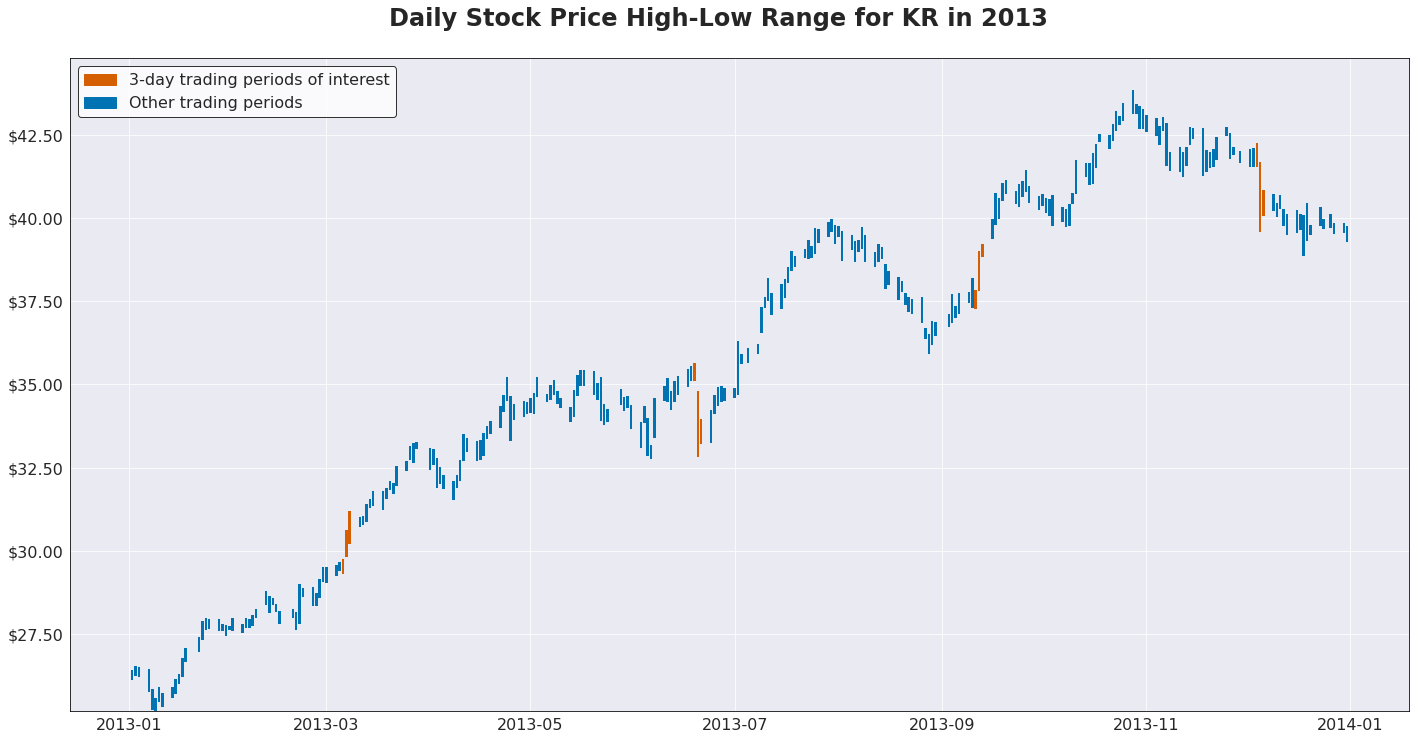

In [46]:
fig, ax = plt.subplots(figsize=(24,12))

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(lambda x, pos: '${:.2f}'.format(x))

subset = daily_data.loc[
    (daily_data['symbol'] == rand_symbol) &
    (daily_data['date'].dt.year == rand_date.year)
]

ax.bar(x=subset['date'], height=subset['high'] - subset['low'], bottom=subset['low'], color=subset['color'], width=.75, linewidth=0)

t = fig.suptitle('Daily Stock Price High-Low Range for {} in {}'.format(rand_symbol, rand_date.year), y=.94, fontsize=24, fontweight='bold')

handle1 = Patch([], [], color=pal[-1], label='3-day trading periods of interest')
handle2 = Patch([], [], color=pal[0], label='Other trading periods')
ax.legend(handles=[handle1, handle2], facecolor='white', edgecolor='black', fontsize=16)

plt.savefig('assets/daily_example.png')

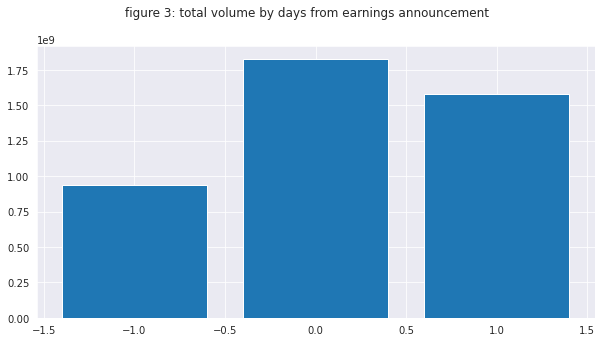

In [12]:
volumes = df.groupby('relative_offset')['volume'].sum()

fig, ax = plt.subplots(figsize=(10,5))

ax.bar(volumes.index, volumes.values)

title = fig.suptitle('figure 3: total volume by days from earnings announcement', y=.99, font={'size' : 18, 'weight' : 'bold'})

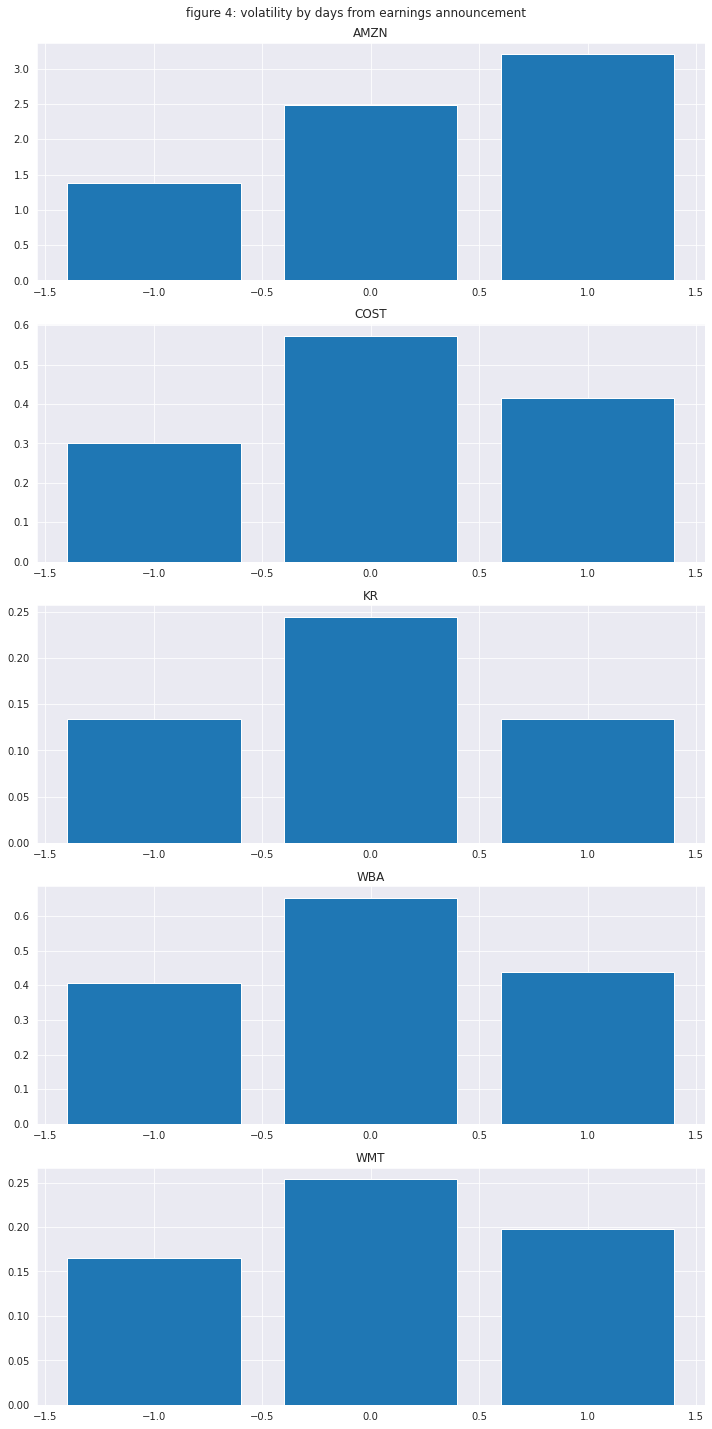

In [13]:
df['mean_price'] = df[['open', 'close', 'high', 'low']].sum(axis=1) / 4

volatility = df.groupby(['symbol', 'earnings_date', 'relative_offset'])['mean_price'].std()
volatility = volatility.groupby(['symbol', 'relative_offset']).mean()

fig, axes = plt.subplots(5, 1, figsize=(10,20))
fig.suptitle('figure 4: volatility by days from earnings announcement', y=.99, font={'size' : 18, 'weight' : 'bold'})

for i, symbol in enumerate(symbols):
    tmp = volatility.loc[(symbol,)]
    ax = axes[i]
    ax.bar(tmp.index, tmp.values)
    ax.set_title(symbol, font={'size' : 12})

plt.tight_layout()

In [14]:
est_differences = estimates_summary['actual'] - estimates_summary['mean_est']

on_date = df.loc[df['relative_offset'] == -1]
after_date = df.loc[df['relative_offset'] > -1]

close_on_date = on_date.groupby(['symbol','earnings_date']).apply(lambda x: x.sort_values('time', ascending=False).iloc[0]['close'])
close_on_date.name = 'close'

open_ix = after_date.sort_values('time').groupby(['symbol', 'earnings_date'])['relative_offset'].idxmin()
open_after_date = after_date.loc[open_ix, 'open'].droplevel('time')

change_after_date_1day = after_date.loc[after_date['relative_offset'] > -1].groupby(['symbol', 'earnings_date']).agg({'high' : 'max', 'low' : 'min'})
change_after_date_1day.columns = ['1day_high', '1day_low']

change_comparison = change_after_date_1day \
                                        .join(close_on_date) \
                                        .join(open_after_date)

# Initital price change
change_comparison['init_price_deviation'] = change_comparison['open'] - change_comparison['close']
change_comparison['init_pct_price_deviation'] = change_comparison['init_price_deviation'] / change_comparison['close']

# Highs / lows day following announcement
large_dev_ix = change_comparison[['1day_high', '1day_low']].sub(change_comparison['close'],axis=0).abs().idxmax(axis=1)
change_comparison['1day_deviation_price'] = change_comparison.apply(lambda x: x[large_dev_ix[x.name]], axis=1)
change_comparison['1day_pct_price_deviation'] = (change_comparison['1day_deviation_price'] - change_comparison['close']) / change_comparison['close']

# # Combine with estimates
estimates_summary['pct_mean_est_deviation'] = (estimates_summary['actual'] - estimates_summary['mean_est']) / estimates_summary['mean_est']
change_comparison = change_comparison.join(estimates_summary)

In [15]:
def direction_table(data, symbol):
    tmp = data.loc[(symbol)]
    
    table = pd.DataFrame({
    'est_direction' : np.sign(tmp['pct_mean_est_deviation']),
    '1day_price_direction' : np.sign(tmp['1day_pct_price_deviation'])
    }).value_counts().unstack(level=-1).fillna(0).round(0).astype(int)
    
    return table

direction_summary = pd.concat([direction_table(change_comparison, symbol) for symbol in symbols], axis=1, keys=symbols)

direction_summary.loc['Total'] = direction_summary.sum(axis=0)
direction_summary['Total'] = direction_summary.sum(axis=1)

## Table 1: summary of initial price changes vs. differences in analyst estimates

In [16]:
direction_summary

AMZN     COST       KR      WBA      WMT     Total
1day_price_direction -1.0 1.0 -1.0 1.0 -1.0 1.0 -1.0 1.0 -1.0 1.0      
est_direction                                                          
-1.0                   11  15    7   6    6   3    2   0   10   5    65
1.0                     1   5    7  12    4  19    6   7    9   8    78
Total                  12  20   14  18   10  22    8   7   19  13   143

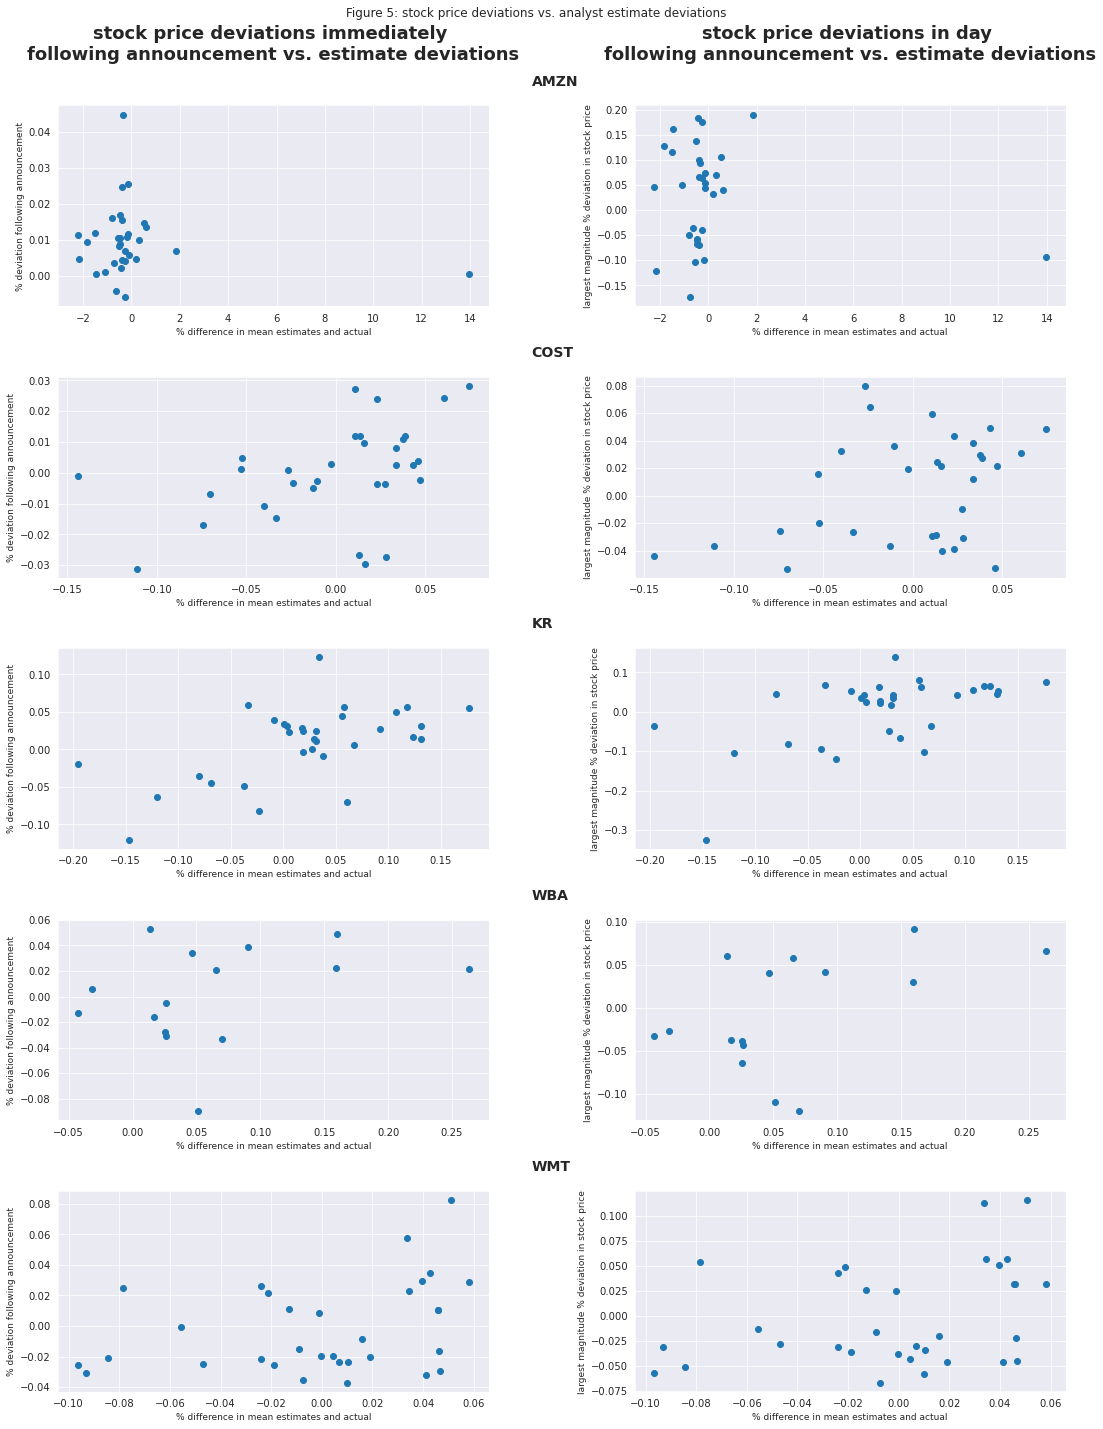

In [17]:
fig, axes = plt.subplots(5,2,figsize=(15,20))


for i, symbol in enumerate(symbols):
    ax = axes[i,0]
    tmp = change_comparison.loc[(symbol)]
    ax.scatter(tmp['pct_mean_est_deviation'], tmp['init_pct_price_deviation'])
    ax.set_xlabel('% difference in mean estimates and actual', font={'size' : 9, 'weight' : 'normal'})
    ax.set_ylabel('% deviation following announcement', font={'size' : 9, 'weight' : 'normal'})
    if i == 0:
        ax.set_title('stock price deviations immediately \nfollowing announcement vs. estimate deviations', y=1.2, font={'size' : 18, 'weight' : 'bold'})
    
    ax.annotate('{}'.format(symbol), xy=(1.1,1.1), xycoords=ax.transAxes, font={'size' : 14, 'weight' : 'bold'})
    
    ax = axes[i,1]
    tmp = change_comparison.loc[(symbol)]
    ax.scatter(tmp['pct_mean_est_deviation'], tmp['1day_pct_price_deviation'])
    ax.set_xlabel('% difference in mean estimates and actual', font={'size' : 9, 'weight' : 'normal'})
    ax.set_ylabel('largest magnitude % deviation in stock price', font={'size' : 9, 'weight' : 'normal'})
    
    if i == 0:
        ax.set_title('stock price deviations in day \nfollowing announcement vs. estimate deviations', y=1.2, font={'size' : 18, 'weight' : 'bold'})
        
fig.suptitle('Figure 5: stock price deviations vs. analyst estimate deviations', y=.99, font={'size' : 18, 'weight' : 'bold'})
        
fig.tight_layout()

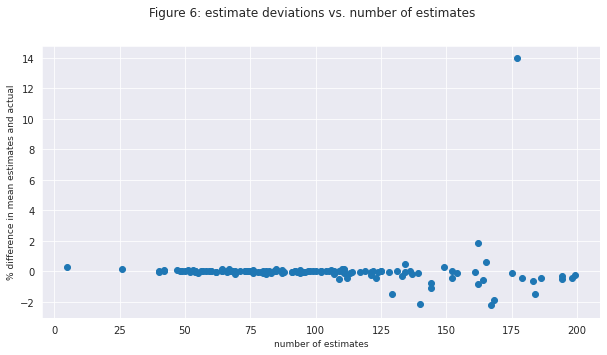

In [18]:
# this differs from the paper

fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(estimates_summary['n_est'], estimates_summary['pct_mean_est_deviation'])

ax.set_xlabel('number of estimates', font={'size' : 9, 'weight' : 'normal'})
ax.set_ylabel('% difference in mean estimates and actual', font={'size' : 9, 'weight' : 'normal'})
title = fig.suptitle('Figure 6: estimate deviations vs. number of estimates', y=.99, font={'size' : 18, 'weight' : 'bold'})

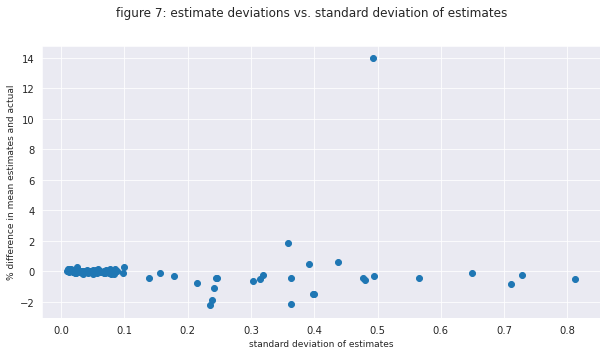

In [19]:
# this differs from the paper

fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(estimates_summary['std_est'], estimates_summary['pct_mean_est_deviation'])

ax.set_xlabel('standard deviation of estimates', font={'size' : 9, 'weight' : 'normal'})
ax.set_ylabel('% difference in mean estimates and actual', font={'size' : 9, 'weight' : 'normal'})
title = fig.suptitle('figure 7: estimate deviations vs. standard deviation of estimates', y=.99, font={'size' : 18, 'weight' : 'bold'})

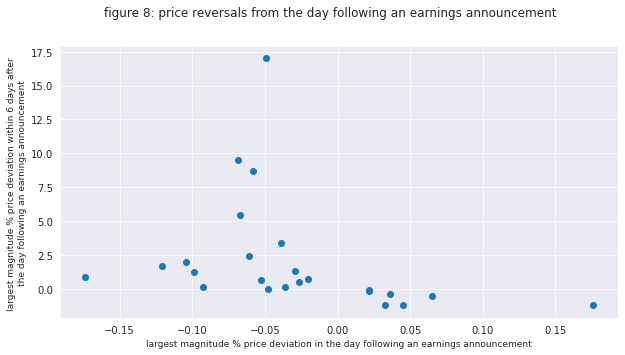

In [20]:
price_reversals = change_comparison.loc[np.sign(change_comparison['1day_pct_price_deviation']) != np.sign(change_comparison['init_price_deviation'])]

fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(price_reversals['1day_pct_price_deviation'], price_reversals['init_price_deviation'])
ax.set_xlabel('largest magnitude % price deviation in the day following an earnings announcement', font={'size' : 9, 'weight' : 'normal'})
ax.set_ylabel('largest magnitude % price deviation within 6 days after \nthe day following an earnings announcement', font={'size' : 9, 'weight' : 'normal'})

title = fig.suptitle('figure 8: price reversals from the day following an earnings announcement', y=.99, font={'size' : 18, 'weight' : 'bold'})

In [21]:
kr_estimates = estimates_summary.loc['KR']
kr_estimates = kr_estimates.loc['2013']

kr_subset = df.loc['KR']
kr_subset = kr_subset.loc['2013']

daily_data.loc[
    (daily_data['symbol'] == 'KR')
    & (daily_data['date'].dt.year == 2013)
]


daily_subset = daily_data.loc[daily_data['date'].dt.year.between(2010,2019)]
daily_subset['earnings_date'] = daily_subset.apply(
    lambda x: x['date'] if x['earning_flag'] else np.nan, axis=1
).fillna(method='bfill')
daily_counts = daily_subset.groupby('earnings_date').apply(lambda x: x.shape[0])
low_counts = daily_counts.loc[daily_counts == 1].index
daily_subset.loc[daily_subset['date'].isin(low_counts), 'earnings_date'] = np.nan
daily_subset['earnings_date'] = daily_subset['earnings_date'].fillna(method='ffill')
daily_subset['earnings_date'] = daily_subset['earnings_date'] + pd.Timedelta(1, unit='d')

kr_daily = daily_subset.loc[
    (daily_data['symbol'] == 'KR')
    & (daily_data['date'].dt.year == 2013)
]

mean_volume = kr_daily.groupby(['earnings_date', 'earning_flag'])['volume'].mean()


kr_price = change_comparison.loc['KR']
kr_price = kr_price.loc['2013']
kr_price = kr_price['1day_pct_price_deviation'] * 100
kr_price.index = kr_price.index.droplevel('date')

kr_volume = ((mean_volume.loc[:,True] - mean_volume.loc[:,False]) / mean_volume.loc[:,False]).dropna() * 100
kr_surprises = kr_estimates['pct_mean_est_deviation'] * 100

kr_data = pd.concat([kr_price, kr_surprises, kr_volume], axis=1)
kr_data.columns = ['price', 'estimate', 'volume']
kr_data.index = kr_data.index.astype(str)

<ipython-input-21-007bfe1a9321>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_subset['earnings_date'] = daily_subset.apply(
/home/nicholas/miniconda3/envs/fin-env/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-21-007bfe1a9321>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

<ipython-input-44-921186f98107>:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  price_patch = Patch([], [], color=pal[0], label='Largest % change in price in day following announcement')
<ipython-input-44-921186f98107>:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  est_patch = Patch([], [], color=pal[1], label='% deviation in EPS from mean analyst estimates')
<ipython-input-44-921186f98107>:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  vol_patch = Patch([], [], color=pal[2], label='% change in average volume from preceding period')


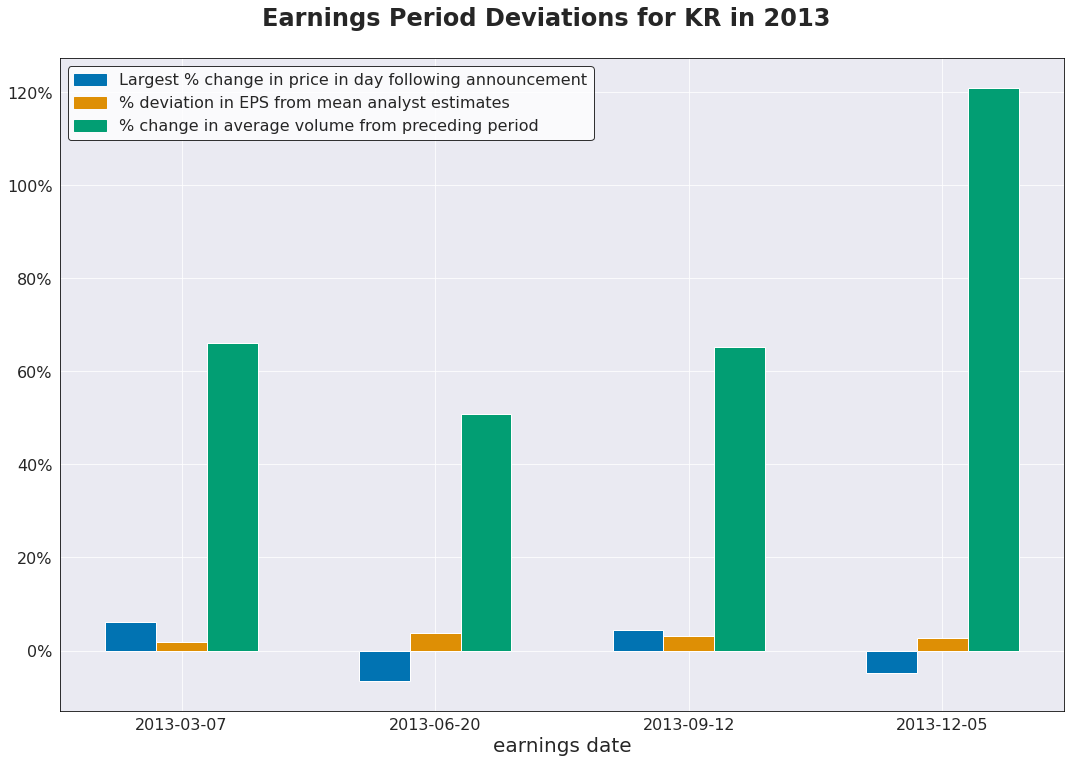

In [44]:
fig, ax = plt.subplots(figsize=(20,12))

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ind = np.arange(4)
width = .2
ax.bar(ind, kr_data['price'], width=width, facecolor=pal[0], edgecolor=None)
ax.bar(ind + width, kr_data['estimate'], width=width, facecolor=pal[1], edgecolor=None)
ax.bar(ind + 2 * width, kr_data['volume'], width=width, facecolor=pal[2], edgecolor=None)
ax.set_xticks(ind + width)
ax.set_xticklabels(kr_data.index, fontsize=16)
ax.set_yticklabels([], fontsize=16)
ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}%'.format(x))

price_patch = Patch([], [], color=pal[0], label='Largest % change in price in day following announcement')
est_patch = Patch([], [], color=pal[1], label='% deviation in EPS from mean analyst estimates')
vol_patch = Patch([], [], color=pal[2], label='% change in average volume from preceding period')

ax.legend(handles=[price_patch, est_patch, vol_patch], facecolor='white', edgecolor='black', fontsize=1)
ax.set_xlabel('earnings date', fontsize=20)

fig.suptitle(
    'Earnings Period Deviations for {} in {}'.format(
        rand_symbol, 
        rand_date.year),
    y=.94,
    fontsize=24,
    fontweight='bold'
)

fig.savefig('assets/deviations_example.png')

Findings
-------

The first noteworthy takeaway comes from observing the periods we're trading in the context of the year. In figure 2, we have our trading periods highlighted in red and can see significant jumps in those periods relative to the rest of the year. While this is just one year for one symbol, we would expect this to be the case for many of our periods. Earnings reports are one of the primary drivers of price movement in stock trading. 

From figure 3, we see that a majority of trading during earnings announcements for these symbols occurs on the day of or the day following the announcement. Intuitively, this should make sense. The discussion and trading around earnings reports reaches a crescendo on the day a company is set to release earnings and traders spend the next day digesting the announcment and reflecting their sentiment in the stock's price.

Figure 4 shows the volatility (measured as the mean standard deviation of average price for the one-minute candles) and generally confirms the same ideas conveyed by figure 2: for the most part, each symbol's maximum amount of uncertainty occurs right before the earnings report is released. One deviation from this trend is for AMZN, which shows the most volatile trading day as the day after the earnings report is released. More analysis would need to be done to confirm this isn't due to an outlier, but if it's the case, we should want our model to be able to pick this up.

Table 1 details price direction on open following an earnings release. The important part is that the open after an earnings announcement doesn't always move in the same direction as the difference between actual EPS and mean analyst estimates. This doesn't really tell us much else without any other information.

Figure 5 compares the magnitude change in the stock price to the magnitude difference in actual EPS and mean analyst estimates. Importantly, we see a clear difference in the graphs between the change at open immediately following an earnings release and the largest magnitude difference seen throughout the 7 days thereafter. This suggests that there is potential in not only predicting the earnings reports and their associated impact on the stock price, but also in the specific trading patterns following the release. Otherwise, the largest deviation in price would occur at open and the price would remain relatively stable for the remainder of our period. A key goal of the model is to interpret and adapt to these patterns.

Figure 6 shows that, at least for these periods and symbols, a stock having a greater number of analyst estimates is somewhat correlated with larger differences between actual and mean estimate. [PAPER] suggests that a greater number of estimates should reflect more certainty regarding the stock, but this claim is made in terms of trading patterns following an earnings report and not the actual difference between actual and estimates, as is shown here.

Figure 7 shows a slight correlation in the data between the standard deviation of the analyst estimates and larger differences between actual and estimates. Altogether, the standard deviation are pretty similar, so it's difficult to draw a lot of conclusions for the low sample size; however, this still suggests that the nuances of the analyst estimates can play some impact on the result.

Lastly, Figure 8 depicts price reversals after the day following an earnings report. The figure does not make much comment on them other than to show that they exist for 70 earnings dates out of the total 282. This is a signficant number and we would hope our model would be able to capture when this might happen based on the trading data.